# Can you help reduce employee turnover?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation.
- "projects" - how many projects the employee is involved in.
- "salary" - for confidentiality reasons, salary comes in three tiers: low, medium, high.
- "tenure" - how many years the employee has been at the company.
- "satisfaction" - a measure of employee satisfaction from surveys.
- "bonus" - 1 if the employee received a bonus in the previous 24 months, 0 otherwise.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee ended up leaving, "no" otherwise.

In [1]:
#Import data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Import statistics functions
from scipy.stats import ttest_ind, ttest_1samp


#Set the plotting style
sns.set()
#Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


## 💪 Competition challenge

Create a report that covers the following:
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

clean the data frame

In [7]:
df_clean = df.copy()
#Turn bonus and promoted into categorical variables
df_clean.bonus = df_clean.bonus.apply(lambda x: ("No Bonus", "Bonus")[x])
df_clean.promoted = df_clean.promoted.apply(lambda x: ("Not Promoted", "Promoted")[x])
#Change the type of tenure, since it is a discrete variable
df_clean.tenure = df_clean.tenure.astype("int64")
#Give the "left" column more descriptive names
df_clean.rename(columns={"left": "departure"}, inplace=True)
df_clean.departure = df_clean.departure.apply(lambda x: ("Stayed", "Left")[x == "yes"])
#Make the department names more appealing
df_clean.department = df.department.apply(lambda x: x.title() if x != "IT" else x)

df_clean.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,departure
0,Operations,Not Promoted,0.577569,3,low,5,0.626759,No Bonus,180.866070,Stayed
1,Operations,Not Promoted,0.751900,3,medium,6,0.443679,No Bonus,182.708149,Stayed
2,Support,Not Promoted,0.722548,3,medium,6,0.446823,No Bonus,184.416084,Stayed
3,Logistics,Not Promoted,0.675158,4,high,8,0.440139,No Bonus,188.707545,Stayed
4,Sales,Not Promoted,0.676203,3,high,5,0.577607,Bonus,179.821083,Stayed


## 1. Which department has the highest employee turnover? Which one has the lowest?

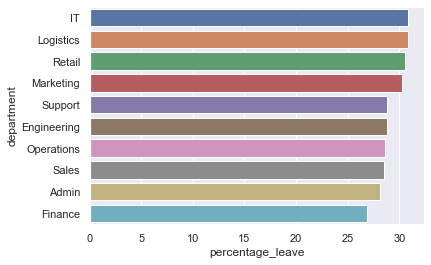

In [8]:
df_departure_pct = (df_clean.groupby("department")["departure"]
            .value_counts(normalize=True) #Get the proportion of people who left within each department
            .mul(100)                     #Convert to percentage
            .rename("percentage_leave")
            .reset_index())
department_left_pct = (df_departure_pct[df_departure_pct.departure == "Left"]
                        .sort_values("percentage_leave", ascending=False) #Sort the df by amount of people who left
                        .drop("departure", axis=1)) 
sns.barplot(data=department_left_pct, y="department", x="percentage_leave")
plt.show()

From the above barplot, we can see that IT has the largest rate of leaving their department with over 30% of people leaving their department. We can also see that logistics, retail and marketing have similar rates of leaving.<br>The Finance department has the lowest rate of leaving their department with just over 25% of employees leaving their department.

## 2. Investigating what causes employees to leave

We want to look at the distributions for the different variables and see if the distributions are different for people who left and the people who stayed. A difference in distributions for a given variable would indicate that that variable is a good indicator of if an employee will leave.

### Continuous Variables

In [9]:
df_clean.describe()

,review,projects,tenure,satisfaction,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.651826,3.274843,6.556184,0.504645,184.661571
std,0.085307,0.579136,1.415432,0.158555,4.144831
min,0.310000,2.000000,2.000000,0.000000,171.374060
25%,0.592884,3.000000,5.000000,0.386801,181.472085
50%,0.647456,3.000000,7.000000,0.500786,184.628796
75%,0.708379,4.000000,8.000000,0.622607,187.728708
max,1.000000,5.000000,12.000000,1.000000,200.861656


From the above summary statistics, we can see that the distributions of the variables are quite different. This will make comparing the variables in the violin plot quite challenging.<br>As such, we will need to conduct feature engineering to make their summary statistics more similar.

In [12]:
def feat_eng(df):
    #Seperate the data into categorical and numeric data types
    df_cat = df.select_dtypes(include="object")
    df_num = df.select_dtypes(exclude="object")
    #Center the data around 0
    df_num -= df_num.mean()
    #Convert all variable's standard deviation to 1
    df_num /= df_num.std()

    return pd.concat([df_cat, df_num], axis=1)
    
def plotting_form(df=df_clean):
    #Returns a data frame that will be easily plotted in a violin plot
    cat_cols = df.select_dtypes(include="object").columns
    return pd.melt(df, id_vars=cat_cols)

In [13]:
#Compare the features after feature engineering
df_eng = feat_eng(df_clean)
df_eng.describe()

,review,projects,tenure,satisfaction,avg_hrs_month
count,9.540000e+03,9.540000e+03,9.540000e+03,9.540000e+03,9.540000e+03
mean,-8.820850e-15,4.835463e-16,-1.226487e-14,-4.824443e-15,1.271351e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.007024e+00,-2.201285e+00,-3.218936e+00,-3.182769e+00,-3.205803e+00
25%,-6.909480e-01,-4.745741e-01,-1.099441e+00,-7.432330e-01,-7.695094e-01
50%,-5.122694e-02,-4.745741e-01,3.135548e-01,-2.433809e-02,-7.907581e-03
75%,6.629284e-01,1.252137e+00,1.020053e+00,7.439815e-01,7.399909e-01
max,4.081431e+00,2.978848e+00,3.846046e+00,3.124184e+00,3.908503e+00


The variables now have similar summary statistics

Plot the violin plots of the different features

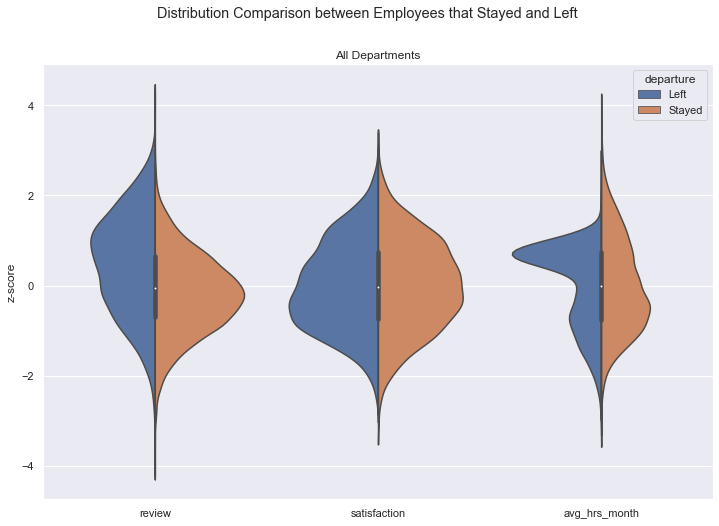

In [31]:
def numerical_turnover_comparison(df=df_clean, ax=None, fig=None, plot=sns.violinplot, is_split=False):
    #Name the subtitle
    subtitle = "All Departments"
    
    #Turn the dataframe into a long, plotting form
    df_norm = feat_eng(df) #Normalize for ease of comparison accross variables
    df_plot = plotting_form(df_norm)
    #Get the variables to plot in a violin plot
    continuous_labels=df.select_dtypes(include="float64").columns

    #Create an axis if none is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    
    #Plot the distributions of the people who left and stayed for the different numerical features
    plot(data=df_plot, x="variable", order=continuous_labels, y="value", hue="departure", hue_order= ["Left", "Stayed"], split=is_split, ax=ax)
    ax.set_title(subtitle)
    ax.set_ylabel("z-score")
    ax.set_xlabel("")
    fig.suptitle("Distribution Comparison between Employees that Stayed and Left")
numerical_turnover_comparison(is_split=True)

From the above, it seems like the review and avg_hrs_month have the most varied distributions between people who left and people who stayed.

<b>Analysis</b><br><br>
People who had a high review score tended to leave the company. This might be due to the fact that high scoring employees have an easier time getting hired at a new company.
<br><br>
People who worked more hours per month tended to stay at the company. This might be because people who work longer hours are too tired to look for another job.<br> Alternatively, this could mean that people who work longer hours tend to have higher satisfaction from their work and thus want to remain at the company. <br>This claim can be verified by analyzing the correlation between these two features, as seen below:

In [34]:
df[["avg_hrs_month", "satisfaction"]].corr()

,avg_hrs_month,satisfaction
avg_hrs_month,1.000000,-0.143142
satisfaction,-0.143142,1.000000


From the above correlation matrix, we see that there is a weak negative correlation between hours worked and job satisfaction. This means that people who work longer hours aren't staying due to high satisfaction. This could mean that they are, in fact, too tired to look for another job but this claim cannot be verified

### Categorical and Discrete Variables

We are now going to look at categorical and discrete variables to determine the probability of an employee leaving if they reside within a group

In [19]:
df_clean.groupby("department").departure.value_counts(normalize=True).mul(100).rename("percentage").reset_index()

,department,departure,percentage
0,Admin,Stayed,71.867612
1,Admin,Left,28.132388
2,Engineering,Stayed,71.174142
3,Engineering,Left,28.825858
4,Finance,Stayed,73.134328
5,Finance,Left,26.865672
6,IT,Stayed,69.101124
7,IT,Left,30.898876
8,Logistics,Stayed,69.166667
9,Logistics,Left,30.833333


From the table above, we can see that there is an uneven amount of people who stayed and left in each department. As such, we will need to sample the dataset with replacement for the probability calculations to not be skewed towards employees staying.

In [35]:
def stratified_sample(df, n_sample=3000, is_replace=True):
    #Create a stratified sample of the data frame, with the department as the strata
    #In order to have informative results, we need to have
    df_strat= df.groupby(["department", "departure"]).apply(lambda x: x.sample(n_sample, replace=is_replace))
    df_strat.index = df_strat.index.droplevel(0)
    #df_strat = sample(df_strat)

    return df_strat

Determine the probability that an employee will leave the company

In [36]:
def get_probability_leave(var, df=df_clean):
    ### Returns a data frame with the probability of an employee leaving

    #Sample the data frame so that there are an equal amount of people who stayed and left in each department
    df_strat = stratified_sample(df, n_sample=100_000)

    df_pct = (df_strat.groupby([var, "department"])["departure"]
                .value_counts(normalize=True)    #Get the proportions of people who left and stayed
                .mul(100).rename("probability")  #Convert the proportions to percentages
                .reset_index())
    #Keep only the percentage of people who left, as the remaining information is redundant
    df_prob_leave = df_pct[df_pct.departure == "Left"].drop("departure", axis=1)
    #Re-order the columns for ease of viewing
    df_prob_leave = df_prob_leave[["department", var, "probability"]]
    #Sort the columns based on predefined orders
    return df_prob_leave.sort_values(["department", var])

Save CSV files of employee churn probabilities for data viz 

In [43]:
def get_var_order(var):
    #Returns the order a variable should be prepresented in a plot
    var_orders = {
        "promoted": ["Not Promoted", "Promoted"],
        "projects": [2,3,4,5],
        "salary": ["low", "medium", "high"],
        "tenure": [2,3,4,5,6,7,8,9],
        "bonus": ["No Bonus", "Bonus"]
        }
    return var_orders[var]
def get_department_order(df=df_clean):
    #Returns the order of departments
    #The order is set by departments with high turnover rates first and low turnover rates last
    
    df_dep = (df.groupby("department")["departure"]
            .value_counts(normalize=True) #Get the proportion of people who left within each department
            .mul(100)                     #Convert to percentage
            .rename("percentage")
            .reset_index())

    department_order = (df_dep[df_dep.departure == "Left"]
                        .sort_values("percentage", ascending=False) #Sort the df by amount of people who left
                        .department)                                #Extract the department names
    return department_order

def get_var_title(var):
    #Returns the x-axis label for a given variable

    x_labels = {
        "promoted": "Received a Promotion within the last 48 months",
        "projects": "# of Projects",
        "salary": "Salaray Range",
        "tenure": "# of Years",
        "bonus": "Received a Bonus within the last 48 months"
    }
    return x_labels[var]

def setup_figure(n_rows=1, n_cols=1, size=8):
    #Returns the figure, axiis, and axis indices for a desired figure

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*size, n_rows*size))
    #Indices for the axiis in the subplots
    ax_inds = ((i,j) for i in range(n_rows) for j in range(n_cols))

    return fig, axs, ax_inds

Evaluate the difference in churn probabilities for all features

In [52]:
def binary_categorical_turnover_comparison(var, df=df_clean):
    #Get the percentage of people who left each department
    df_pct_leave = get_probability_leave(var, df)
    #Add a new column to improve legend readability
    var_title = get_var_title(var)
    df_pct_leave[var_title] = df_pct_leave[var]

    #Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.barplot(data=df_pct_leave, y="department", order=get_department_order(), x="probability", hue=var_title, hue_order=get_var_order(var))
    ax.set_title(f"Probability of an Employee Leaving Based on the \n{var.title()} Variable")
    ax.set_xlabel("Probability of Leaving")
    ax.set_ylabel("Department")
    #Show data as a proportion of 100%
    ax.set_xlim(right=100)
    #Convert xticks to a percentage
    xticks = ax.get_xticks()
    ax.set_xticklabels(f"{int(xtick)}%" for xtick in xticks)
    plt.show()

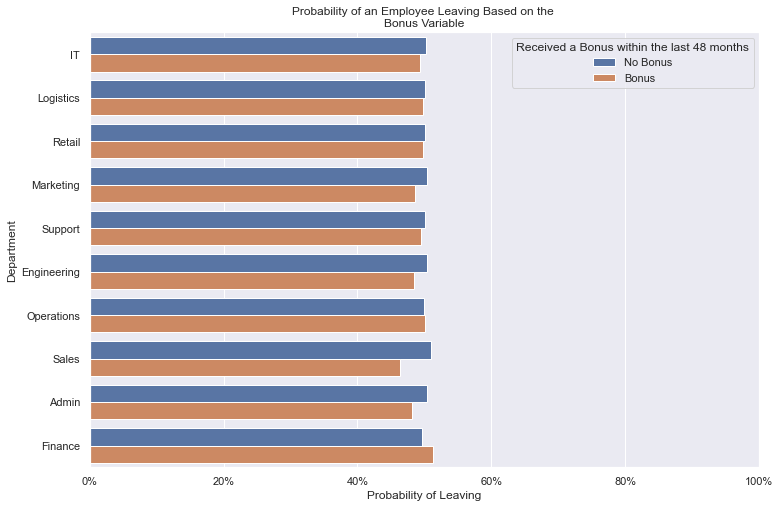

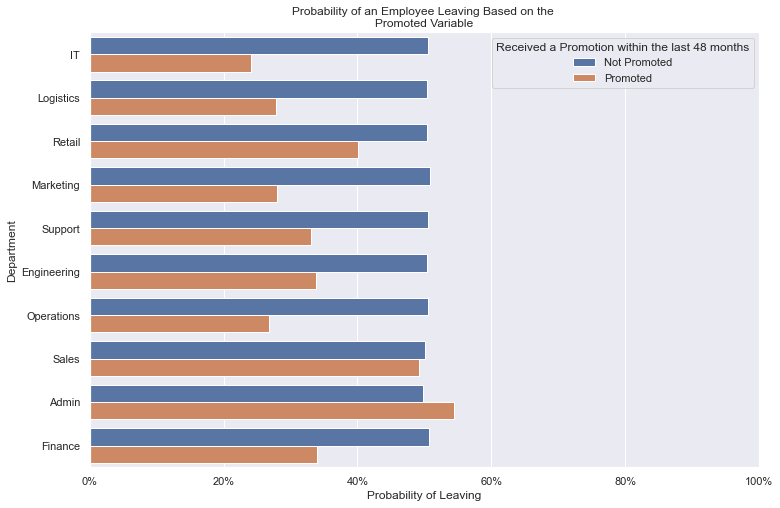

In [53]:
binary_categorical_turnover_comparison("bonus")
binary_categorical_turnover_comparison("promoted")

<b>Analysis</b><br><br>
As we can see from the above plots, giving an employee a bonus does not seem to change the probability that they will leave the company, but promoting an employee significantly decreases the probability that they will leave in all departments except for Sales and Admin

Evaluate the Discrete Non-Binary Variables

In [77]:
def categorical_turnover_comparison(department=None, df=df_clean):
    #Define the non-binary categorical variables and discrete variables
    discrete_vars = ["salary", "projects", "tenure"]

    #If no department is specified, then display aggregation for all departments
    if department is None:
        subtitle = "All Departments"
    else:
        subtitle = f"the {department} Department"
        #Extract the data for the given department
        df = df[df.department == department]
    

    #Setup the figure
    fig, axs, ax_inds = setup_figure(n_rows=1, n_cols=3, size=8)

    #Plot the probabilities for each discrete variable
    for var, ax_ind in zip(discrete_vars, ax_inds):
        ax = axs[ax_ind[1]]
        df_prob_leave = get_probability_leave(var, df)

        #We want a barplot for the categorical variables and a lineplot for the discrete variables
        if var == "salary":
            sns.barplot(data=df_prob_leave, x=var, order=get_var_order(var), y="probability", ax=ax)
        else:
            sns.lineplot(data=df_prob_leave, x=var, y="probability", ax=ax)
        ax.set_xlabel(get_var_title(var))
        ax.set_ylabel("Probability of Employee Churn")
        ax.set_title(f"{var.title()} Variable")

        #Convert yticks to a percentage
        yticks = ax.get_yticks()
        ax.set_yticklabels(f"{int(ytick)}%" for ytick in yticks)

    fig.suptitle(f"Analysis For \n{subtitle}")
    plt.show()

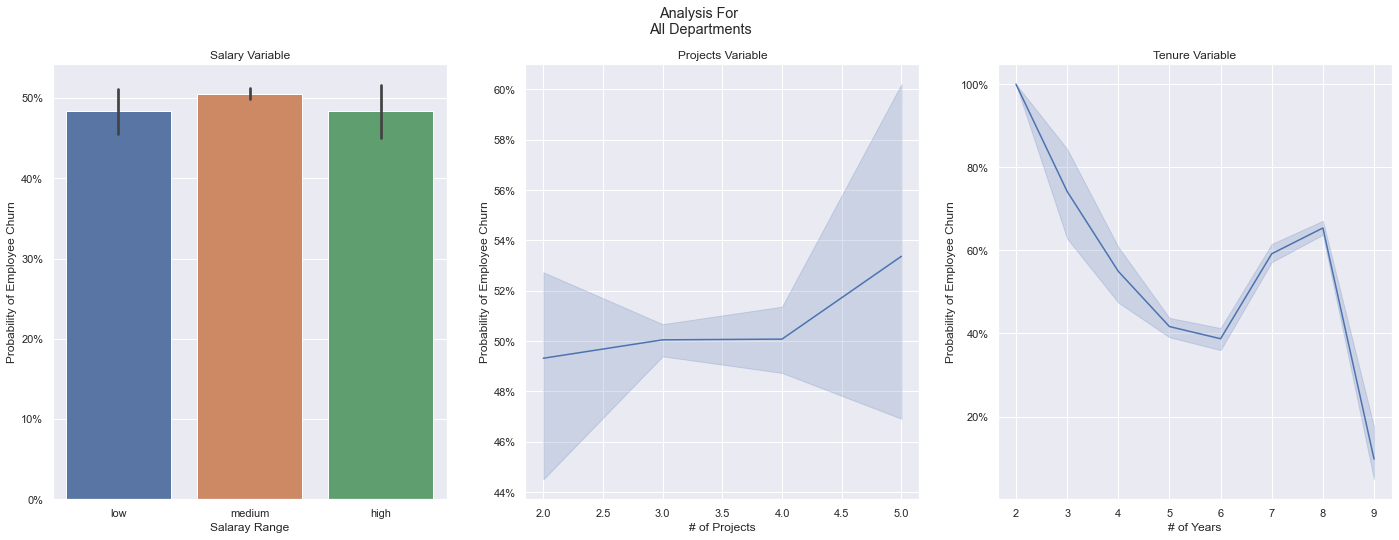

In [78]:
categorical_turnover_comparison()

<b>Analysis</b><br><br>
From the above, we can see that the churn probability is related to the number of projects worked on by an employee and the tenure of the employee.<br>Employees working on more projects tend to have a higher churn probability and employees with more tenure tend to have lower churn probability (with some variance between 6 and 8 years of tenure).
<br><br>
However, we can also note that there is a high variability (as noted by the error bars and ranges) so we will look at each department individually

Looking at each department

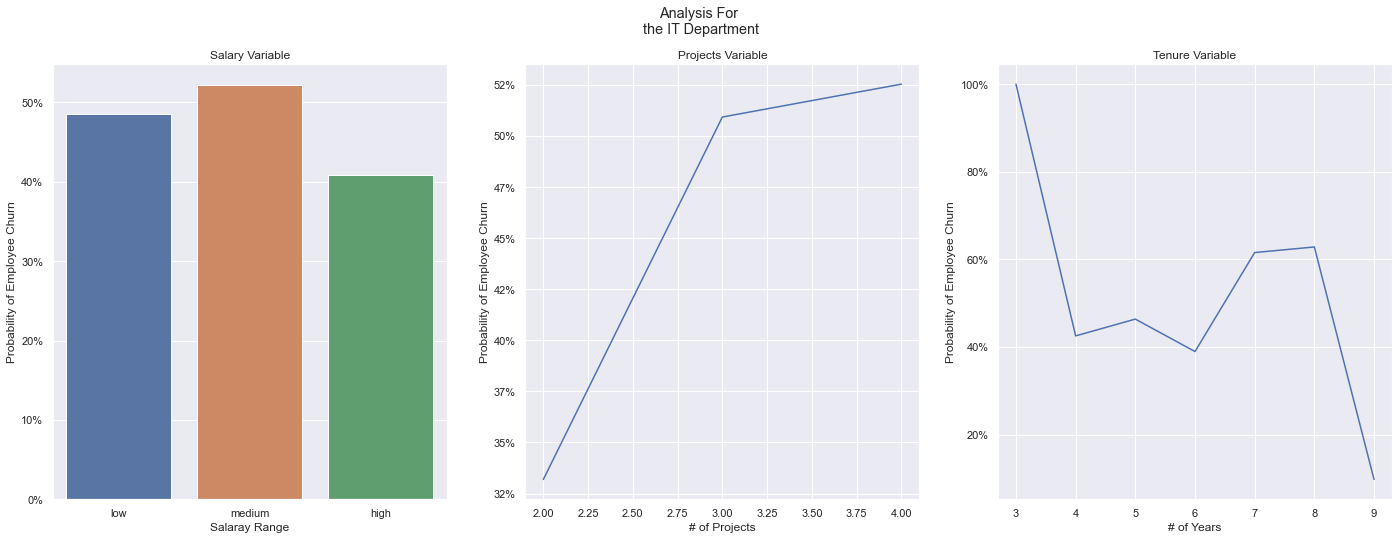

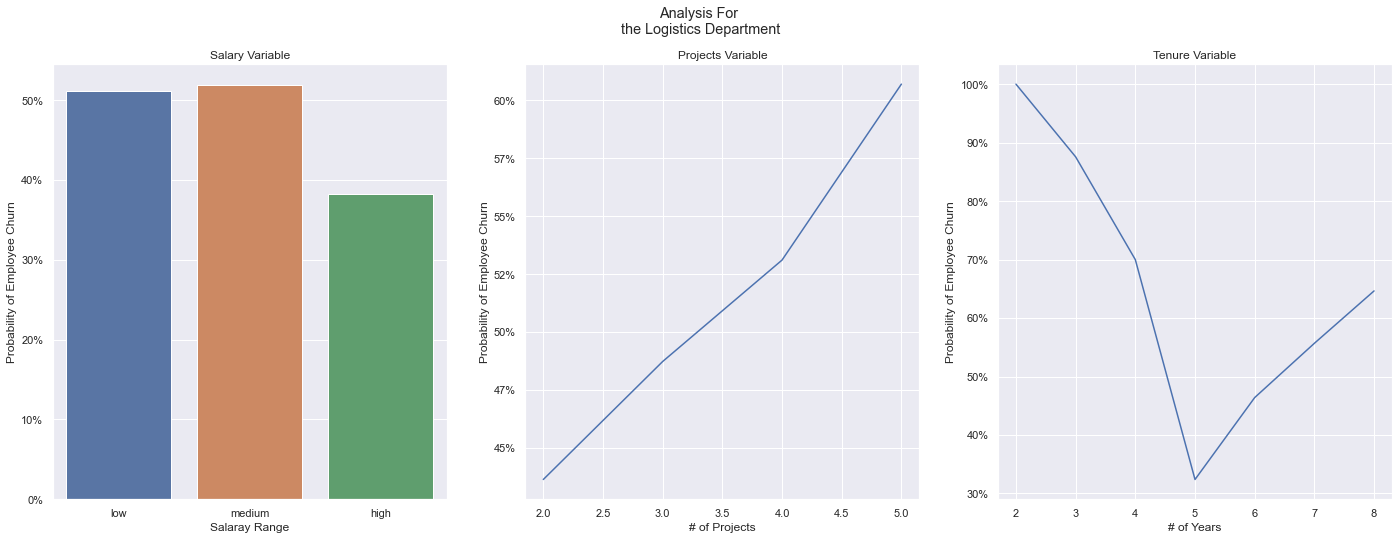

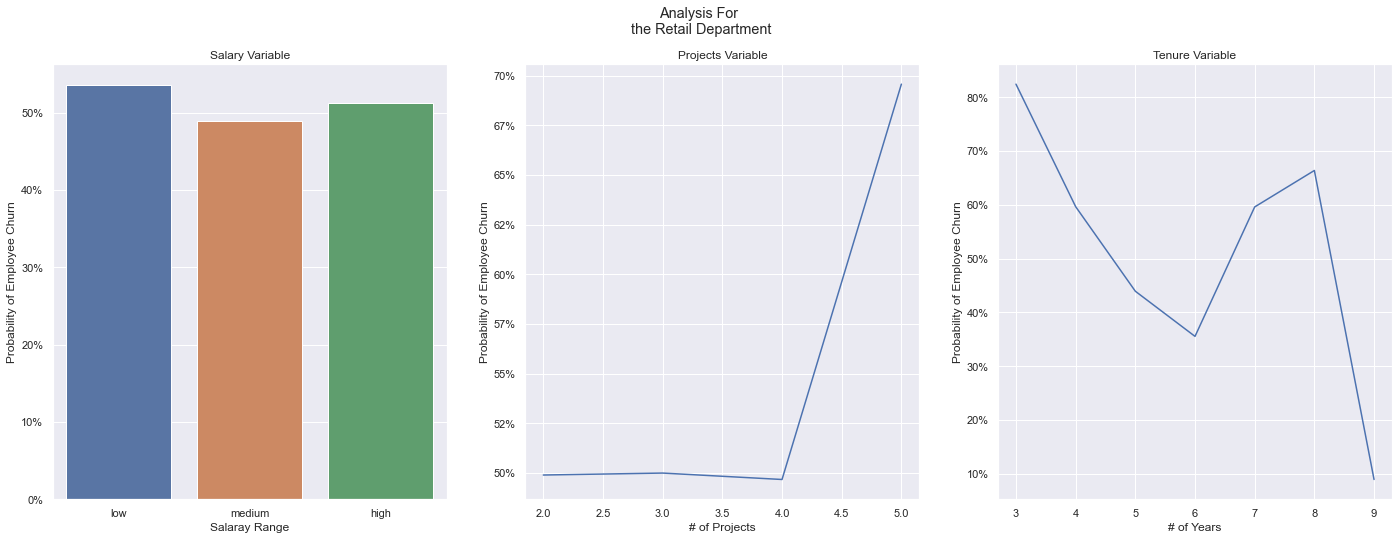

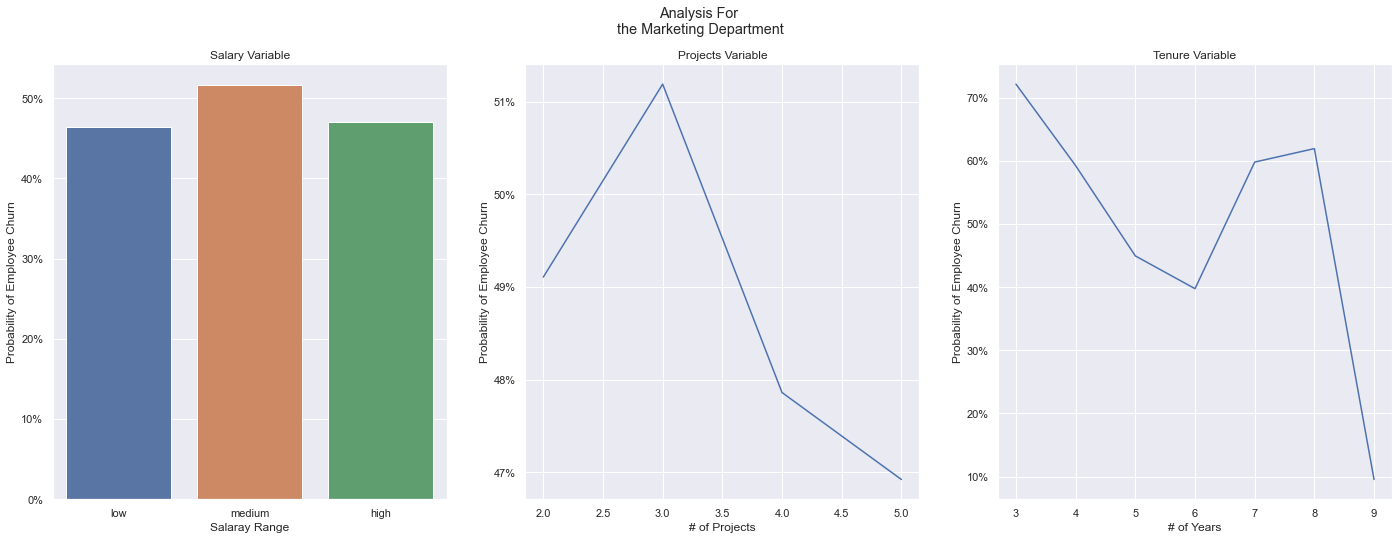

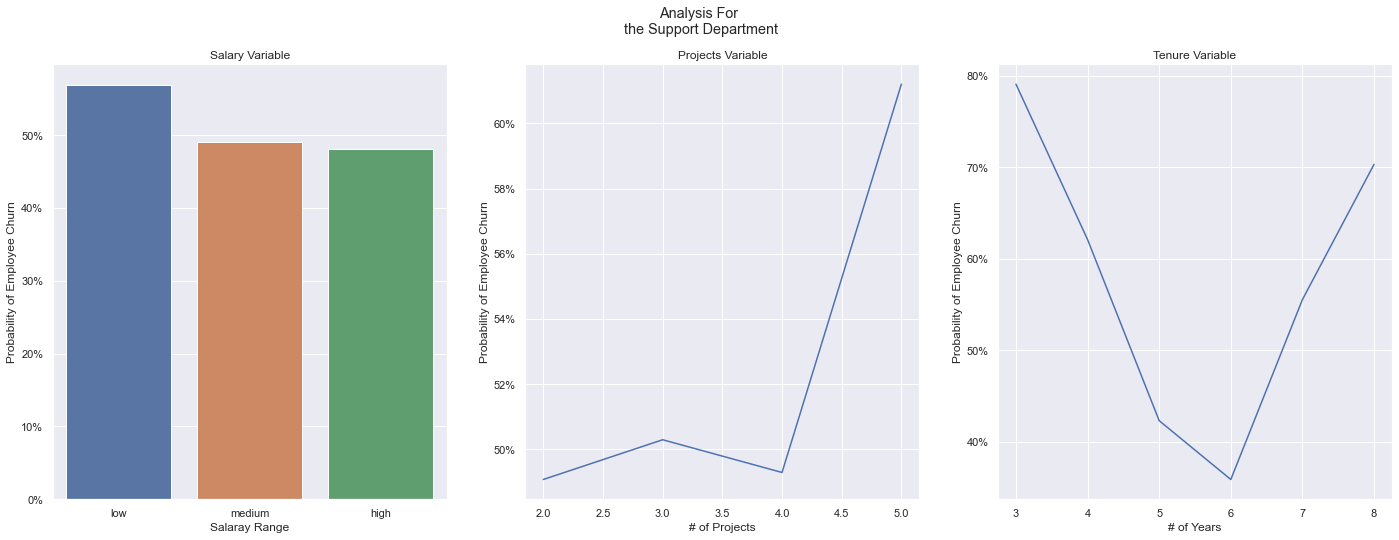

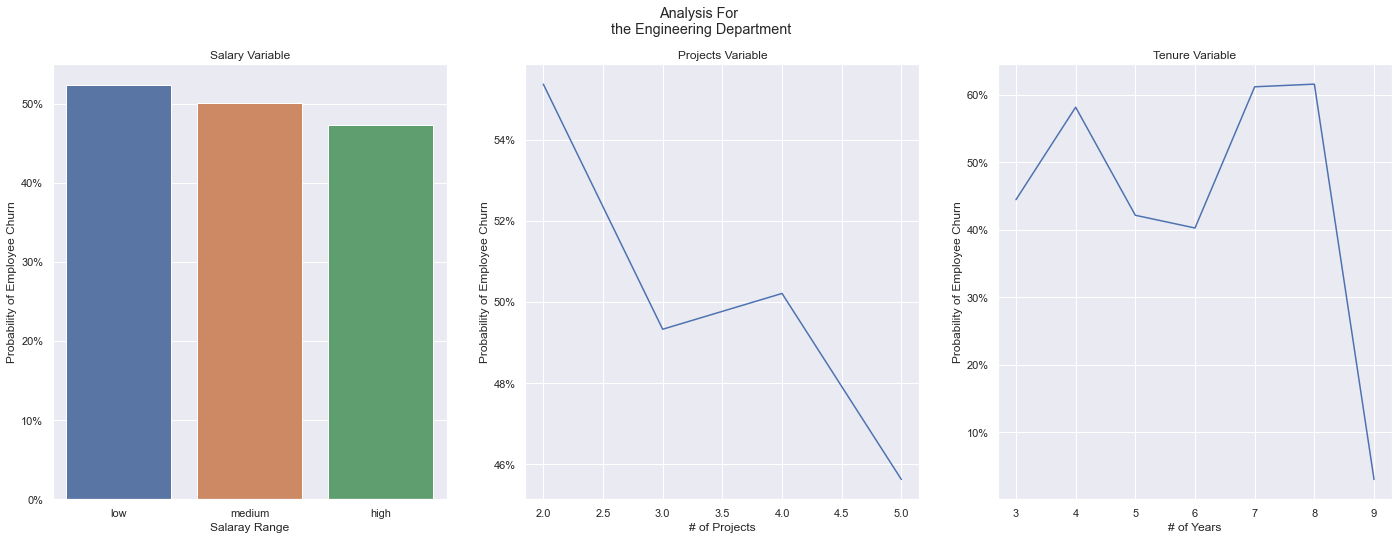

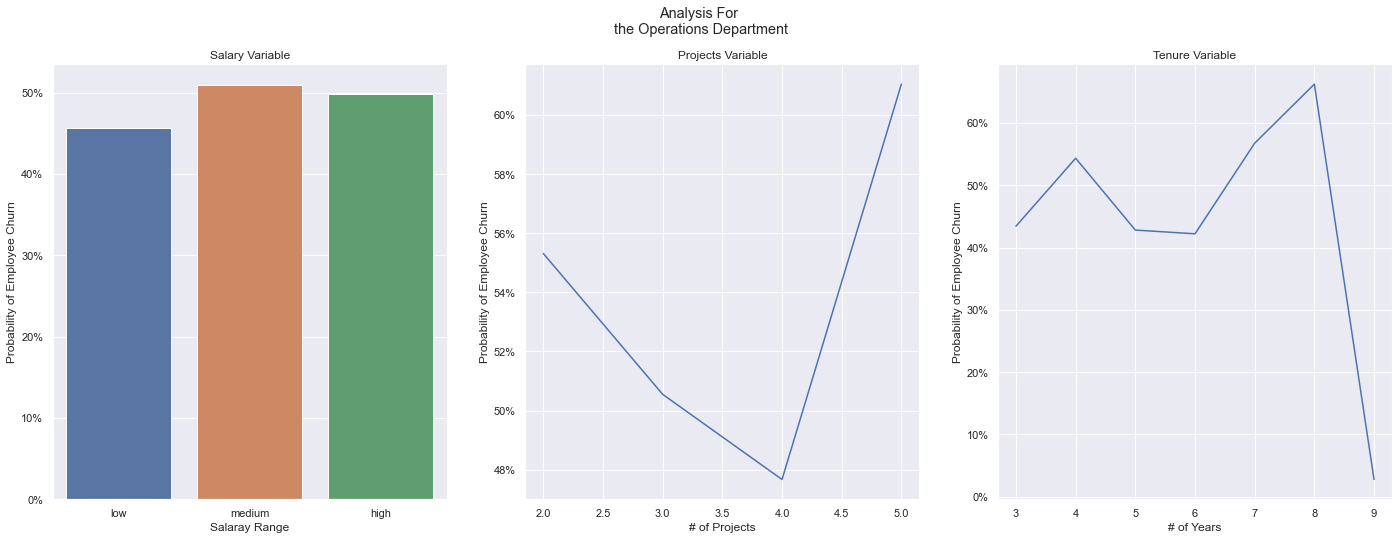

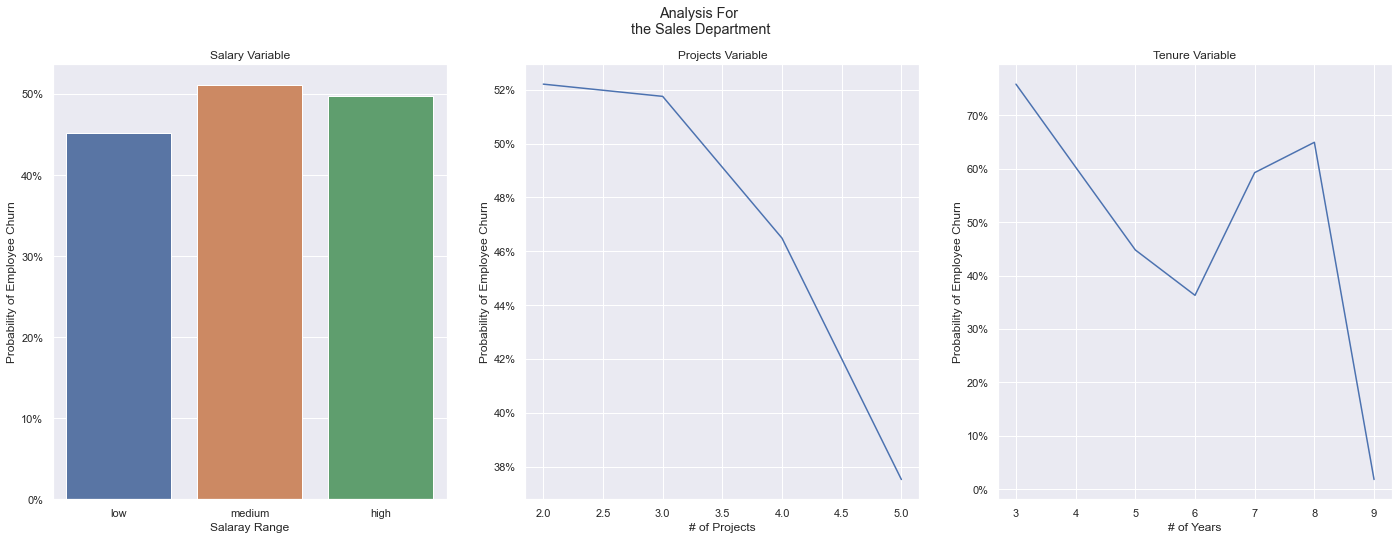

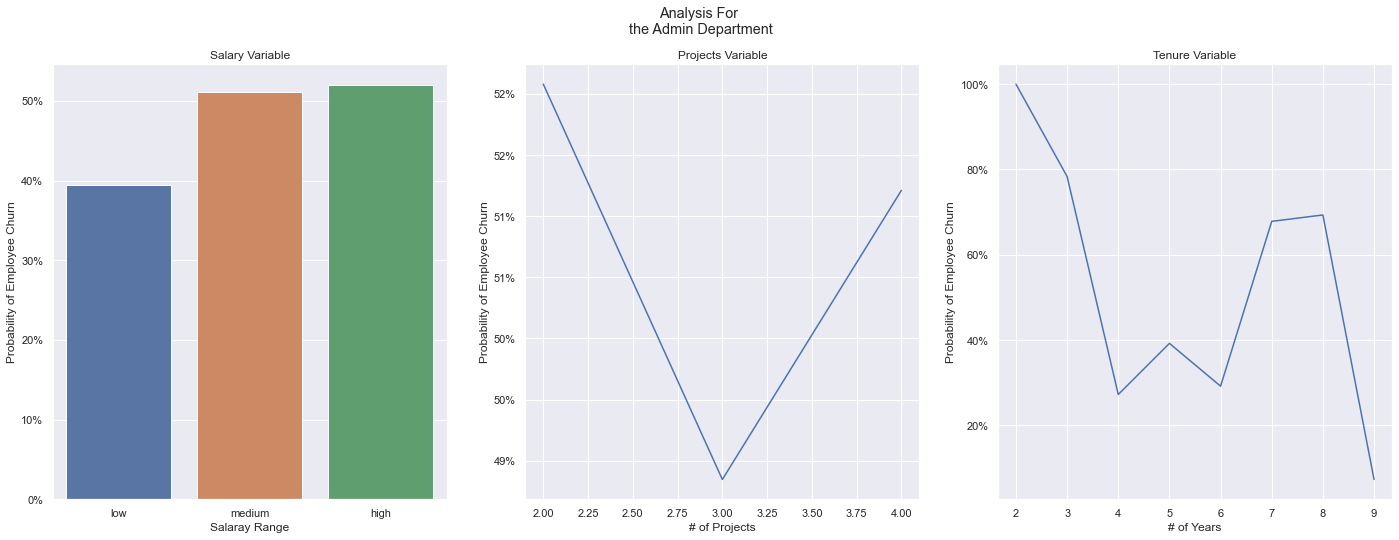

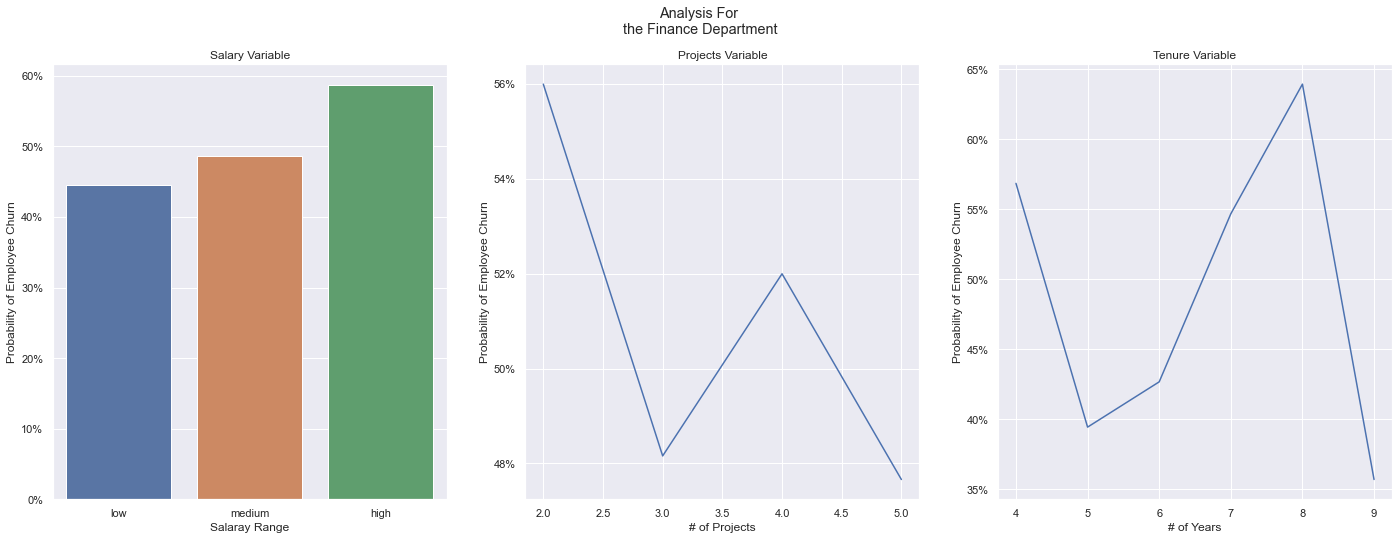

In [79]:
for department in get_department_order():
    categorical_turnover_comparison(department)

From the above, we can see that the trends in churn probability vary from department to department, so we will create a dashboard to have cleaner access to each departments' churn trends.

In [80]:
#Save the churn probabilities for each variable
probability_leave_vars = ["promoted", "projects", "salary", "tenure", "bonus"]
for var in probability_leave_vars:
    get_probability_leave(var).to_csv(f"data/{var}_prob.csv")